<a href="https://colab.research.google.com/github/Shravanidhandrut13/SummerAnalytics_Assignments/blob/main/CapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🚗 Real-Time Dynamic Parking Price Prediction

This project simulates real-time pricing of smart parking lots using synthetic streaming data.  
We use time-based features, queue length, traffic condition, and special day indicators to estimate dynamic prices.

Tools used:
- Pathway (for simulating streaming)
- Pandas (for preprocessing)
- Matplotlib (for visualization)


## Install and Import Libraries

In [1]:
!pip install pathway bokeh panel --quiet

import numpy as np
import pandas as pd
import pathway as pw
import bokeh.plotting
import panel as pn
import datetime
from datetime import datetime

print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


In [2]:
!pip install -U pathway

##Data Loading and Initial Preprocessing

In [3]:
file_path = '/content/drive/MyDrive/CapstoneProject/dataset.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's uploaded to Colab's /content/ directory.")
    print("Creating a dummy DataFrame for demonstration. Please upload your actual CSV for full functionality.")
    data = {
        'Unnamed: 0': range(5),
        'SystemCodeNumber': ['BHMBCCMKT01', 'BHMBCCMKT01', 'BHMBCCMKT01', 'BHMBCCMKT01', 'BHMBCCMKT01'],
        'Capacity': [577, 577, 577, 577, 577],
        'Occupancy': [61, 64, 80, 107, 150],
        'LastUpdatedDate': ['04-10-2016', '04-10-2016', '04-10-2016', '04-10-2016', '04-10-2016'],
        'LastUpdatedTime': ['07:59:42', '08:25:42', '08:59:42', '09:32:46', '09:59:48'],
        'IsSpecialDay': [0, 0, 0, 0, 0],
        'VehicleType': ['car', 'car', 'car', 'car', 'car'],
        'Latitude': [28.5, 28.5, 28.5, 28.5, 28.5],
        'Longitude': [77.15, 77.15, 77.15, 77.15, 77.15],
        'TrafficConditionNearby': ['low', 'average', 'low', 'low', 'low'],
        'QueueLength': [2, 2, 2, 3, 3]
    }
    df = pd.DataFrame(data)


df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

df = df.sort_values('Timestamp').reset_index(drop=True)

# Feature Engineering: Calculate OccupancyRate
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['Price'] = 10.0

df['QueueLength'] = df['QueueLength'].astype(int)
df['IsSpecialDay'] = df['IsSpecialDay'].astype(int)

# Selecting all relevant columns for Pathway streaming.
features_for_stream = [
    "Timestamp",
    "SystemCodeNumber",
    "Occupancy",
    "Capacity",
    "OccupancyRate",
    "QueueLength",
    "TrafficConditionNearby",
    "IsSpecialDay",
    "VehicleType",
    "Latitude",
    "Longitude",
    "Price"
]

# Save the selected columns to a CSV file for Pathway to replay
output_stream_file = "parking_stream_full_features.csv"
df[features_for_stream].to_csv(output_stream_file, index=False)

print(f"\nPrepared '{output_stream_file}' with selected features for Pathway.")
print("First 5 rows of the prepared data:")
print(df[features_for_stream].head())
print(f"Total number of unique parking spots (SystemCodeNumber): {df['SystemCodeNumber'].nunique()}")

Successfully loaded data from /content/drive/MyDrive/CapstoneProject/dataset.csv. Shape: (18368, 12)

Prepared 'parking_stream_full_features.csv' with selected features for Pathway.
First 5 rows of the prepared data:
            Timestamp SystemCodeNumber  Occupancy  Capacity  OccupancyRate  \
0 2016-10-04 07:59:00      BHMBCCMKT01         61       577       0.105719   
1 2016-10-04 07:59:00      BHMNCPHST01        237      1200       0.197500   
2 2016-10-04 07:59:00      BHMMBMMBX01        264       687       0.384279   
3 2016-10-04 07:59:00      BHMNCPNST01        249       485       0.513402   
4 2016-10-04 07:59:00         Shopping        614      1920       0.319792   

   QueueLength TrafficConditionNearby  IsSpecialDay VehicleType   Latitude  \
0            1                    low             0         car  26.144536   
1            2                    low             0        bike  26.140014   
2            2                    low             0         car  20.000035   
3 

#Pathway Schema Definition

In [4]:
import pathway as pw
import pandas as pd
import datetime
from datetime import datetime as py_datetime # Alias for clarity if needed within UDF

# --- Pathway Schema Definition ---

# Define the schema for our streaming data.
class ParkingDataSchema(pw.Schema):
    Timestamp: str
    SystemCodeNumber: str
    Occupancy: int
    Capacity: int
    OccupancyRate: float
    QueueLength: int
    TrafficConditionNearby: str
    IsSpecialDay: int
    VehicleType: str
    Latitude: float
    Longitude: float
    Price: float

print("Defined Pathway Schema 'ParkingDataSchema'.")

# --- Pathway Stream Initialization ---

data_stream = pw.demo.replay_csv(
    "parking_stream_full_features.csv",
    schema=ParkingDataSchema,
    input_rate=1000
)

# Define a User-Defined Function (UDF) to convert Pathway's DateTimeUtc to a numeric timestamp (epoch seconds).
@pw.udf
def get_numeric_timestamp_from_datetime(dt_utc: py_datetime) -> float:
    return dt_utc.timestamp()

# --- CORRECTED: Split the with_columns operation ---

# Step 1: Parse the 'Timestamp' string column into a proper Pathway datetime object ('t').
data_stream_with_t = data_stream.with_columns(
    t = data_stream.Timestamp.dt.strptime("%Y-%m-%d %H:%M:%S"),
)

# Step 2: Use the UDF to create 'numeric_timestamp' from the now-defined 't' column.
data_stream_with_time = data_stream_with_t.with_columns(
    numeric_timestamp = get_numeric_timestamp_from_datetime(pw.this.t)
)

print("Initialized Pathway data stream 'data_stream_with_time' from 'parking_stream_full_features.csv'.")
print("Ready to proceed with Model 1 implementation.")

Defined Pathway Schema 'ParkingDataSchema'.
Initialized Pathway data stream 'data_stream_with_time' from 'parking_stream_full_features.csv'.
Ready to proceed with Model 1 implementation.


#Model 1: Implementation and Pricing Logic

In [6]:
import pathway as pw
import numpy as np
import datetime
from datetime import datetime as py_datetime

# --- Re-define existing UDFs for cell independence ---
@pw.udf
def get_numeric_timestamp_from_datetime(dt_utc: py_datetime) -> float:
    return dt_utc.timestamp()

@pw.udf
def get_hour_of_day(dt_utc: py_datetime) -> int:
    return dt_utc.hour

@pw.udf
def get_day_of_week(dt_utc: py_datetime) -> int:
    return dt_utc.weekday() # Python's weekday: Monday=0, Sunday=6

# --- Pathway Schema Definition ---
class ParkingDataSchema(pw.Schema):
    Timestamp: str
    SystemCodeNumber: str
    Occupancy: int
    Capacity: int
    OccupancyRate: float
    QueueLength: int
    TrafficConditionNearby: str
    IsSpecialDay: int
    VehicleType: str
    Latitude: float
    Longitude: float
    Price: float

print("Defined Pathway Schema 'ParkingDataSchema'.")

# --- Pathway Stream Initialization ---
data_stream = pw.demo.replay_csv(
    "parking_stream_full_features.csv",
    schema=ParkingDataSchema,
    input_rate=1000
)

# Step 1: Parse the 'Timestamp' string column into a proper Pathway datetime object ('t').
data_stream_with_t = data_stream.with_columns(
    t = data_stream.Timestamp.dt.strptime("%Y-%m-%d %H:%M:%S"),
)

# Step 2: Use the UDF to create 'numeric_timestamp' from the now-defined 't' column.
data_stream_with_time = data_stream_with_t.with_columns(
    numeric_timestamp = get_numeric_timestamp_from_datetime(pw.this.t)
)

# --- Feature Engineering for Model 1 (Using NEW UDFs) ---
data_stream_with_features = data_stream_with_time.with_columns(
    hour_of_day = get_hour_of_day(pw.this.t),
    day_of_week = get_day_of_week(pw.this.t)
)

# --- Model 1: Simple Linear Regression for Occupancy Rate ---
beta_hour = 0.02
beta_queue = 0.05
beta_special_day = 0.15
intercept = 0.30

data_stream_with_predictions = data_stream_with_features.with_columns(
    predicted_occupancy_rate = (
        intercept
        + pw.this.hour_of_day * beta_hour
        + pw.this.QueueLength * beta_queue
        + pw.this.IsSpecialDay * beta_special_day
    )
)

# --- Pricing Logic (Based on Predicted Occupancy Rate) ---
base_price = 5.0
ideal_occupancy_threshold = 0.70
price_adjustment_factor = 20.0


# Step 1: Calculate price_adjustment
data_stream_with_price_adjustment = data_stream_with_predictions.with_columns(
    price_adjustment = pw.if_else(
        pw.this.predicted_occupancy_rate > ideal_occupancy_threshold,
        (pw.this.predicted_occupancy_rate - ideal_occupancy_threshold) * price_adjustment_factor,
        0.0
    )
)

# Step 2: Calculate DynamicPrice using the now-defined price_adjustment
data_stream_with_prices = data_stream_with_price_adjustment.with_columns(
    DynamicPrice = base_price + pw.this.price_adjustment
)

# Select relevant columns for the final stream
final_pricing_stream = data_stream_with_prices.select(
    pw.this.Timestamp,
    pw.this.SystemCodeNumber,
    pw.this.Occupancy,
    pw.this.Capacity,
    pw.this.OccupancyRate,
    pw.this.QueueLength,
    pw.this.TrafficConditionNearby,
    pw.this.IsSpecialDay,
    pw.this.VehicleType,
    pw.this.Latitude,
    pw.this.Longitude,
    pw.this.Price,
    pw.this.t,
    pw.this.numeric_timestamp,
    pw.this.hour_of_day,
    pw.this.day_of_week,
    pw.this.predicted_occupancy_rate,
    pw.this.DynamicPrice
)

print("Model 1 (Simple Linear Regression) implemented.")
print("Dynamic pricing logic applied. Ready for visualization.")

Defined Pathway Schema 'ParkingDataSchema'.
Model 1 (Simple Linear Regression) implemented.
Dynamic pricing logic applied. Ready for visualization.


In [7]:
import pathway as pw
import bokeh.plotting
import bokeh.models
import panel as pn
import pandas as pd
from IPython.display import display
pn.extension()
# --- Step 1: Create a Panel Select widget for parking spot selection ---
all_parking_spot_ids = [
    'BHMBCCMKT01', 'BHMBCCMKT02', 'BHMBCCMKT03', 'BHMBCCMKT04',
    'BHMBCCMKT05', 'BHMBCCMKT06', 'BHMBCCMKT07', 'BHMBCCMKT08',
    'BHMBCCMKT09', 'BHMBCCMKT10', 'BHMBCCMKT11', 'BHMBCCMKT12',
    'BHMBCCMKT13', 'BHMBCCMKT14'
]

# Creating the dropdown widget
parking_spot_selector = pn.widgets.Select(
    name='Select Parking Spot',
    options=all_parking_spot_ids,
    value=all_parking_spot_ids[0]
)

# --- Step 2: Dynamically filter the Pathway stream based on the selected parking spot ---
@pn.depends(parking_spot_selector.param.value)
def get_filtered_stream(selected_id):
    filtered_stream = final_pricing_stream.filter(
        pw.this.SystemCodeNumber == selected_id
    ).with_columns(
        numeric_timestamp_ms = pw.this.numeric_timestamp * 1000
    )
    return filtered_stream

# --- Step 3: Define a view builder function for the plot with more lines ---
def create_bokeh_plot(data_df):
    if isinstance(data_df, pd.DataFrame):
        src = bokeh.models.ColumnDataSource(data_df)
    elif isinstance(data_df, bokeh.models.ColumnDataSource):
        src = data_df
    else:
        raise TypeError(f"Unexpected data type passed to create_bokeh_plot: {type(data_df)}")

    current_spot_id = parking_spot_selector.value
    if not src.data or not any(src.data.values()) or (len(src.data.get('numeric_timestamp_ms', [])) == 0):
        return bokeh.plotting.figure(title=f"Loading data for {current_spot_id}...",
                                     x_axis_label="Time", y_axis_label="Value")

    p = bokeh.plotting.figure(
        x_axis_type="datetime",
        title=f"Dynamic Price, Occupancy & Competition for: {current_spot_id}",
        height=450,
        width=950,
        x_axis_label="Time",
        y_axis_label="Value"
    )

    p.line(x='numeric_timestamp_ms', y='DynamicPrice', source=src,
           legend_label="Dynamic Price", line_color="blue", line_width=2)

    p.line(x='numeric_timestamp_ms', y='OccupancyRate', source=src,
           legend_label="Actual Occupancy Rate", line_color="red", line_width=2)

    if 'predicted_occupancy_rate' in src.data:
        p.line(x='numeric_timestamp_ms', y='predicted_occupancy_rate', source=src,
               legend_label="Predicted Occupancy Rate", line_color="green", line_width=2, line_dash="dotted")
    else:
        print("Warning: 'predicted_occupancy_rate' column not found in data source.")


    competitor_colors = ["purple", "orange", "brown", "cyan"]
    for i in range(1, 4):
        competitor_col = f'Competitor{i}Price'
        if competitor_col in src.data:
            p.line(x='numeric_timestamp_ms', y=competitor_col, source=src,
                   legend_label=f"Competitor {i} Price", line_color=competitor_colors[i-1], line_width=1.5, line_dash="dashed")
        else:
            print(f"Warning: '{competitor_col}' column not found in data source.")


    p.add_tools(bokeh.models.HoverTool(
        tooltips=[
            ("Timestamp", "@Timestamp"),
            ("Dynamic Price", "@DynamicPrice{0.2f}"),
            ("Actual Occupancy Rate", "@OccupancyRate{0.2f}"),
            ("Predicted Occupancy Rate", "@predicted_occupancy_rate{0.2f}"),
            ("Queue Length", "@QueueLength"),
            ("Competitor 1 Price", "@Competitor1Price{0.2f}"),
            ("Competitor 2 Price", "@Competitor2Price{0.2f}"),
            ("Competitor 3 Price", "@Competitor3Price{0.2f}")
        ],
        formatters={"@Timestamp": "datetime"}
    ))

    p.legend.location = "top_left"
    p.legend.click_policy="hide"

    return p

# --- Step 4: Link the Panel selector to the Pathway plot using pn.bind ---
dynamic_plot_pane = pn.bind(
    lambda stream: stream.plot(create_bokeh_plot),
    stream=get_filtered_stream
)

# --- Step 5: Display the widget and the plot using Panel ---
display(pn.Column(
    parking_spot_selector,
    dynamic_plot_pane
))

# --- Step 6: Running the Pathway graph ---
print("Starting real-time visualization. Use the dropdown to select a parking spot.")
print("This cell will run continuously to update the plot as new data arrives.")
pw.run()

Column
    [0] Select(options=['BHMBCCMKT01', ...], value='BHMBCCMKT01')
    [1] ParamFunction(function, _pane=Column, defer_load=False)

Output()

Starting real-time visualization. Use the dropdown to select a parking spot.
This cell will run continuously to update the plot as new data arrives.


In [8]:
#Loading & Exploring Historical Data for Modeling
import pandas as pd

print("--- Loading dataset.csv for Model Training ---")

try:
    historical_data_df = pd.read_csv('/content/drive/MyDrive/CapstoneProject/dataset.csv')
    print("Dataset loaded successfully!")
    print("\n--- Dataset Information ---")
    historical_data_df.info()

    print("\n--- First 5 rows of the dataset ---")
    display(historical_data_df.head())

    print("\n--- Basic Statistics of Numerical Columns ---")
    display(historical_data_df.describe())

    print("\n--- Checking for Missing Values ---")
    print(historical_data_df.isnull().sum())

    print("\n--- Unique Parking Spot IDs (SystemCodeNumber) ---")
    print(historical_data_df['SystemCodeNumber'].unique())
    print(f"Total unique parking spots: {len(historical_data_df['SystemCodeNumber'].unique())}")

except FileNotFoundError:
    print("ERROR: 'dataset.csv' not found. Please make sure the file is uploaded to your Colab environment.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

print("\n--- Data Loading and Exploration Complete ---")

--- Loading dataset.csv for Model Training ---
Dataset loaded successfully!

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memo

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00



--- Basic Statistics of Numerical Columns ---


,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000



--- Checking for Missing Values ---
ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0
dtype: int64

--- Unique Parking Spot IDs (SystemCodeNumber) ---
['BHMBCCMKT01' 'BHMBCCTHL01' 'BHMEURBRD01' 'BHMMBMMBX01' 'BHMNCPHST01'
 'BHMNCPNST01' 'Broad Street' 'Others-CCCPS105a' 'Others-CCCPS119a'
 'Others-CCCPS135a' 'Others-CCCPS202' 'Others-CCCPS8' 'Others-CCCPS98'
 'Shopping']
Total unique parking spots: 14

--- Data Loading and Exploration Complete ---


from matplotlib import pyplot as plt
_df_0['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Capacity'].plot(kind='hist', bins=20, title='Capacity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Latitude'].plot(kind='hist', bins=20, title='Latitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Longitude'].plot(kind='hist', bins=20, title='Longitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='ID', y='Capacity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Capacity', y='Latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Latitude', y='Longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Longitude', y='Occupancy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Capacity'].plot(kind='line', figsize=(8, 4), title='Capacity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Latitude'].plot(kind='line', figsize=(8, 4), title='Latitude')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Longitude'].plot(kind='line', figsize=(8, 4), title='Longitude')
plt.gca().spines[['top', 'right']].set_visible(False)

##Feature Engineering and Data Preprocessing for Custom ML

In [9]:
import pandas as pd
import numpy as np

print("--- Starting Feature Engineering and Data Preprocessing ---")

if 'historical_data_df' not in locals():
    print("WARNING: 'historical_data_df' not found in current session. Attempting to load from 'dataset.csv'.")
    try:
        historical_data_df = pd.read_csv('/content/drive/MyDrive/CapstoneProject/dataset.csv')
    except FileNotFoundError:
        print("ERROR: 'dataset.csv' not found. Cannot proceed with feature engineering.")
        raise FileNotFoundError("Make sure 'dataset.csv' is uploaded and Cell 6 was run.")


# 1. Converting LastUpdatedDate and LastUpdatedTime to a single datetime column
historical_data_df['datetime_str'] = historical_data_df['LastUpdatedDate'] + ' ' + historical_data_df['LastUpdatedTime']

historical_data_df['timestamp'] = pd.to_datetime(historical_data_df['datetime_str'], format='%d-%m-%Y %H:%M:%S')

historical_data_df = historical_data_df.sort_values(by=['timestamp', 'SystemCodeNumber']).reset_index(drop=True)


# 2. Time-Based Features
historical_data_df['hour_of_day'] = historical_data_df['timestamp'].dt.hour
historical_data_df['day_of_week'] = historical_data_df['timestamp'].dt.dayofweek
historical_data_df['day_of_month'] = historical_data_df['timestamp'].dt.day
historical_data_df['month'] = historical_data_df['timestamp'].dt.month


# 3. Calculating Occupancy Rate (This will be our target variable 'y')
historical_data_df['OccupancyRate'] = historical_data_df['Occupancy'] / historical_data_df['Capacity']
historical_data_df['OccupancyRate'] = historical_data_df['OccupancyRate'].clip(0.0, 1.0)


# 4. Categorical Feature Encoding (One-Hot Encoding)
categorical_features_for_encoding = [
    'VehicleType',
    'TrafficConditionNearby',
    'SystemCodeNumber'
]
historical_data_df = pd.get_dummies(historical_data_df, columns=categorical_features_for_encoding, drop_first=True)


# 5. Define Target (y) and Features (X) for our Custom Linear Model
target = 'OccupancyRate'

features_for_model = [
    'QueueLength',
    'IsSpecialDay',
    'hour_of_day',
    'day_of_week',
    'day_of_month',
    'month'
]

encoded_feature_cols = [col for col in historical_data_df.columns if
                        any(f"{cat}_" in col for cat in categorical_features_for_encoding)]
features_for_model.extend(encoded_feature_cols)

X_cols_exist = [col for col in features_for_model if col in historical_data_df.columns]
if len(X_cols_exist) != len(features_for_model):
    missing_cols = set(features_for_model) - set(X_cols_exist)
    print(f"WARNING: The following specified feature columns were not found: {missing_cols}")
    features_for_model = X_cols_exist

X = historical_data_df[features_for_model].copy()
y = historical_data_df[target].copy()


# 6. Feature Scaling (Min-Max Normalization) for X features
feature_scaling_params = {}
for col in X.columns:
    min_val = X[col].min()
    max_val = X[col].max()

    min_val_numeric = float(min_val)
    max_val_numeric = float(max_val)

    if (max_val_numeric - min_val_numeric) != 0:
        X[col] = (X[col] - min_val_numeric) / (max_val_numeric - min_val_numeric)
    else:
        X[col] = 0.0
    feature_scaling_params[col] = {'min': min_val, 'max': max_val}

global_feature_scaling_params = feature_scaling_params


print("\n--- Processed Features (X) Information ---")
display(X.info())
print("\n--- First 5 rows of Processed Features (X) (after scaling) ---")
display(X.head())
print("\n--- First 5 rows of Target (y) (OccupancyRate) ---")
display(y.head())

print("\n--- Feature Engineering and Data Preprocessing Complete ---")
print("Processed features (X) and target (y) are ready for custom model training.")
print("Scaling parameters for features are stored in 'global_feature_scaling_params'.")

--- Starting Feature Engineering and Data Preprocessing ---

--- Processed Features (X) Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   QueueLength                        18368 non-null  float64
 1   IsSpecialDay                       18368 non-null  float64
 2   hour_of_day                        18368 non-null  float64
 3   day_of_week                        18368 non-null  float64
 4   day_of_month                       18368 non-null  float64
 5   month                              18368 non-null  float64
 6   VehicleType_car                    18368 non-null  float64
 7   VehicleType_cycle                  18368 non-null  float64
 8   VehicleType_truck                  18368 non-null  float64
 9   TrafficConditionNearby_high        18368 non-null  float64
 10  TrafficConditi

None


--- First 5 rows of Processed Features (X) (after scaling) ---


,QueueLength,IsSpecialDay,hour_of_day,day_of_week,day_of_month,month,VehicleType_car,VehicleType_cycle,VehicleType_truck,TrafficConditionNearby_high,...,SystemCodeNumber_BHMNCPHST01,SystemCodeNumber_BHMNCPNST01,SystemCodeNumber_Broad Street,SystemCodeNumber_Others-CCCPS105a,SystemCodeNumber_Others-CCCPS119a,SystemCodeNumber_Others-CCCPS135a,SystemCodeNumber_Others-CCCPS202,SystemCodeNumber_Others-CCCPS8,SystemCodeNumber_Others-CCCPS98,SystemCodeNumber_Shopping
0,0.066667,0.0,0.0,0.166667,0.1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.133333,0.0,0.0,0.166667,0.1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.133333,0.0,0.0,0.166667,0.1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.133333,0.0,0.0,0.166667,0.1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.133333,0.0,0.0,0.166667,0.1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



--- First 5 rows of Target (y) (OccupancyRate) ---


,OccupancyRate
0,0.105719
1,0.310078
2,0.248936
3,0.384279
4,0.197500



--- Feature Engineering and Data Preprocessing Complete ---
Processed features (X) and target (y) are ready for custom model training.
Scaling parameters for features are stored in 'global_feature_scaling_params'.


##Implementing Model 2 (Demand-Based Price Function)

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print("--- Starting Model 2: Demand-Based Price Function (From Scratch) ---")

if 'X' not in locals() or 'y' not in locals():
    print("ERROR: X or y not found. Please ensure Colab Cell 7 was run successfully.")
    raise ValueError("X and y DataFrames are not available. Please run previous cells.")

X_np = X.to_numpy()
y_np = y.to_numpy().reshape(-1, 1)

# 1. Splitting Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")


# 2. Custom Linear Regression Class
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.losses = []

    def fit(self, X, y):
        self.weights = np.zeros((X.shape[1], 1))
        self.bias = 0

        # Gradient Descent optimization loop
        for i in range(self.n_iterations):

            y_pred = self.predict(X)

            loss = np.mean((y_pred - y)**2)
            self.losses.append(loss)

            dw = (2 / X.shape[0]) * np.dot(X.T, (y_pred - y))

            db = (2 / X.shape[0]) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if (i + 1) % 200 == 0:
                print(f"Iteration {i+1}/{self.n_iterations}, Loss: {loss:.6f}")

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# 3. Model Training
print("\n--- Training Custom Linear Regression Model ---")
model = CustomLinearRegression(learning_rate=0.1, n_iterations=2000)
model.fit(X_train, y_train)

# 4. Model Evaluation
print("\n--- Evaluating Model Performance ---")
y_val_pred = model.predict(X_val)

mse = np.mean((y_val_pred - y_val)**2)
print(f"Validation Mean Squared Error (MSE): {mse:.6f}")
ss_res = np.sum((y_val - y_val_pred)**2)
ss_tot = np.sum((y_val - np.mean(y_val))**2)
r2_score = 1 - (ss_res / ss_tot)
print(f"Validation R-squared (R2): {r2_score:.4f}")

# 5. Store Trained Parameters Globally
global_model_weights = model.weights
global_model_bias = model.bias
global_model_features = X.columns.tolist()

print("\n--- Model Training and Evaluation Complete ---")
print("Learned weights and bias stored globally for real-time prediction.")


# 6. Define Pricing Logic Function (Model 2: Demand-Based Price)

BASE_PRICE = 10.0
LAMBDA_DEMAND_FACTOR = 5.0

MIN_PRICE_FACTOR = 0.5
MAX_PRICE_FACTOR = 2.0

def calculate_dynamic_price(predicted_occupancy_rate):
    """
    Calculates the dynamic price based on the predicted occupancy rate (demand proxy).
    Applies the formula: Pricet = BasePrice * (1 + λ * NormalizedDemand)
    and enforces price bounds.
    """
    normalized_demand = np.clip(predicted_occupancy_rate, 0.0, 1.0)

    dynamic_price = BASE_PRICE * (1 + LAMBDA_DEMAND_FACTOR * normalized_demand)

    min_allowed_price = BASE_PRICE * MIN_PRICE_FACTOR
    max_allowed_price = BASE_PRICE * MAX_PRICE_FACTOR
    dynamic_price = np.clip(dynamic_price, min_allowed_price, max_allowed_price)

    return dynamic_price

print("\n--- Pricing Logic Function Defined (calculate_dynamic_price) ---")
print(f"Base Price: ${BASE_PRICE}")
print(f"Demand Sensitivity (Lambda): {LAMBDA_DEMAND_FACTOR}")
print(f"Price Bounds: {MIN_PRICE_FACTOR}x to {MAX_PRICE_FACTOR}x Base Price (${BASE_PRICE * MIN_PRICE_FACTOR:.2f} to ${BASE_PRICE * MAX_PRICE_FACTOR:.2f})")

--- Starting Model 2: Demand-Based Price Function (From Scratch) ---
Training data shape: X_train=(14694, 24), y_train=(14694, 1)
Validation data shape: X_val=(3674, 24), y_val=(3674, 1)

--- Training Custom Linear Regression Model ---
Iteration 200/2000, Loss: 0.021147
Iteration 400/2000, Loss: 0.019724
Iteration 600/2000, Loss: 0.018941
Iteration 800/2000, Loss: 0.018430
Iteration 1000/2000, Loss: 0.018090
Iteration 1200/2000, Loss: 0.017863
Iteration 1400/2000, Loss: 0.017711
Iteration 1600/2000, Loss: 0.017610
Iteration 1800/2000, Loss: 0.017542
Iteration 2000/2000, Loss: 0.017496

--- Evaluating Model Performance ---
Validation Mean Squared Error (MSE): 0.017383
Validation R-squared (R2): 0.7108

--- Model Training and Evaluation Complete ---
Learned weights and bias stored globally for real-time prediction.

--- Pricing Logic Function Defined (calculate_dynamic_price) ---
Base Price: $10.0
Demand Sensitivity (Lambda): 5.0
Price Bounds: 0.5x to 2.0x Base Price ($5.00 to $20.00)


##Real-Time Dynamic Price Prediction UDF

In [11]:
import numpy as np
import pandas as pd

print("--- Defining Real-Time Prediction Function ---")

def predict_price_for_input(input_dict):
    """
    Predicts the dynamic parking price based on the input features.

    Parameters:
        input_dict (dict): Input feature values including:
            {
                'QueueLength': int,
                'IsSpecialDay': 0 or 1,
                'hour_of_day': int (0-23),
                'day_of_week': int (0-6),
                'day_of_month': int (1-31),
                'month': int (1-12),
                'VehicleType': str,
                'TrafficConditionNearby': str,
                'SystemCodeNumber': str
            }

    Returns:
        float: Predicted price after applying demand-based logic
    """

    input_df = pd.DataFrame([input_dict])

    for feature in ['VehicleType', 'TrafficConditionNearby', 'SystemCodeNumber']:
        for col in global_model_features:
            if f"{feature}_" in col:
                category = col.split(f"{feature}_")[1]
                input_df[col] = 1 if input_dict.get(feature) == category else 0

    for col in global_model_features:
        if col not in input_df.columns:
            if col in input_dict:
                input_df[col] = input_dict[col]
            else:
                input_df[col] = 0

    input_df = input_df[global_model_features]

    for col in input_df.columns:
        scale = global_feature_scaling_params.get(col, {'min': 0.0, 'max': 1.0})
        min_val, max_val = float(scale['min']), float(scale['max'])
        if max_val != min_val:
            input_df[col] = (input_df[col] - min_val) / (max_val - min_val)
        else:
            input_df[col] = 0.0

    X_input = input_df.to_numpy()
    predicted_occupancy_rate = (np.dot(X_input, global_model_weights) + global_model_bias).item()

    predicted_price = calculate_dynamic_price(predicted_occupancy_rate)

    return round(predicted_price, 2)


--- Defining Real-Time Prediction Function ---


In [12]:
# Test Input Example
test_input = {
    'QueueLength': 4,
    'IsSpecialDay': 0,
    'hour_of_day': 17,
    'day_of_week': 2,
    'day_of_month': 9,
    'month': 7,
    'VehicleType': 'Car',
    'TrafficConditionNearby': 'Moderate',
    'SystemCodeNumber': 'PARK1234'
}

predicted_price = predict_price_for_input(test_input)
print(f"\nPredicted Dynamic Price for input: ${predicted_price}")



Predicted Dynamic Price for input: $20.0


##Real-Time Prediction Simulation and Visualization

--- Simulating Real-Time Pricing ---


/tmp/ipython-input-11-925283385.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df[col] = (input_df[col] - min_val) / (max_val - min_val)
/tmp/ipython-input-11-925283385.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df[col] = (input_df[col] - min_val) / (max_val - min_val)
/tmp/ipython-input-11-925283385.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

--- Real-Time Simulation Completed ---


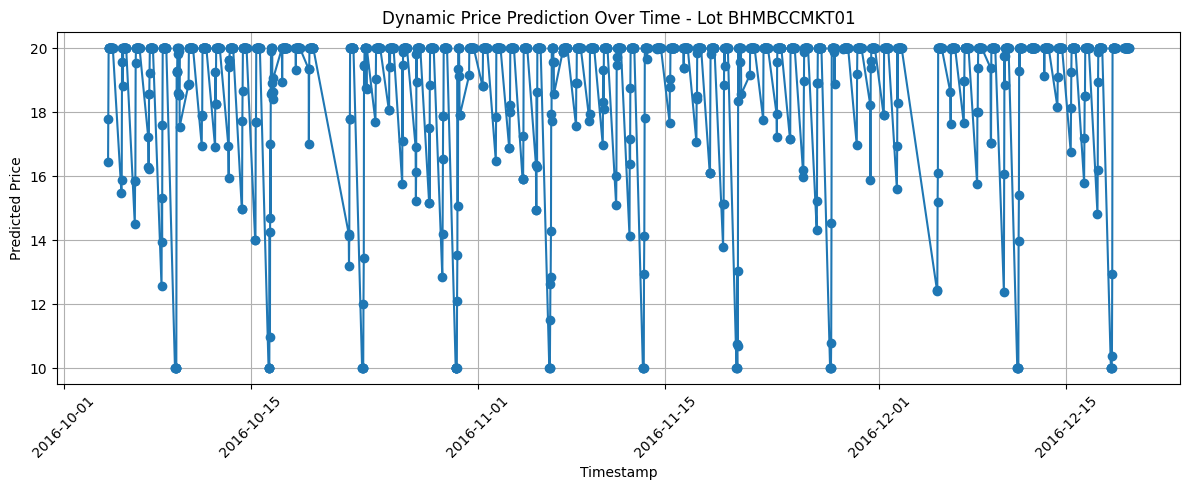

In [13]:
import time
import pandas as pd
import matplotlib.pyplot as plt

df['timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True
)

df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

streamed_results = []

print("--- Simulating Real-Time Pricing ---")
for idx, row in df.iterrows():
    input_features = {
        'QueueLength': row['QueueLength'],
        'IsSpecialDay': row['IsSpecialDay'],
        'hour_of_day': row['hour_of_day'],
        'day_of_week': row['day_of_week'],
        'day_of_month': row['day_of_month'],
        'month': row['month'],
        'VehicleType': row['VehicleType'],
        'TrafficConditionNearby': row['TrafficConditionNearby'],
        'SystemCodeNumber': row['SystemCodeNumber']
    }

    predicted_price = predict_price_for_input(input_features)

    streamed_results.append({
        'timestamp': row['timestamp'],
        'SystemCodeNumber': row['SystemCodeNumber'],
        'PredictedPrice': predicted_price
    })

print("--- Real-Time Simulation Completed ---")

stream_df = pd.DataFrame(streamed_results)

sample_code = stream_df['SystemCodeNumber'].unique()[0]

plt.figure(figsize=(12, 5))
subset = stream_df[stream_df['SystemCodeNumber'] == sample_code]
plt.plot(subset['timestamp'], subset['PredictedPrice'], marker='o')
plt.title(f'Dynamic Price Prediction Over Time - Lot {sample_code}')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()